In [52]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection

mpl.rcParams['pdf.fonttype'] = 42
plt.rc('axes', labelsize=12)

In [53]:
outdir = "/home/AD/rkgadde/L1IP/mC_data/CZI/type/mC"

me_type = "Alu"
var_type = "insertion" # absence or insertion
binsize = 100

In [54]:
# if 'L1' in me_type:
#     xlim = [-2000,2000]
# elif 'Alu' in me_type:
#     xlim = [-1000,1000]

In [55]:
var = var_type[:3]
var_file = f"{outdir}/binc-{binsize}.{me_type}_{var}.all_samples.parquet.gz"

In [56]:
df = pd.read_parquet(var_file)
df.head()

,id,bin,sample,celltype,mc,cov,ctxt,genotype
0,CZI_ins_758,750,AM2,MGE_SST,3,3,mCG,NoAlu
1,CZI_ins_758,350,AM2,MGE_SST,1,1,mCG,NoAlu
2,CZI_ins_758,250,AM2,MGE_SST,18,18,mCG,NoAlu
3,CZI_ins_758,150,AM2,MGE_SST,8,8,mCG,NoAlu
4,CZI_ins_758,50,AM2,MGE_SST,4,4,mCG,NoAlu


In [57]:
df['bin'].unique()

array([ 750,  350,  250,  150,   50,  -50, -150, -250, -350, -450, -550,
       -750, -850, -950,  950,  850,  650,  550,  450, -650], dtype=int16)

In [58]:
# lower = xlim[0]
# upper = xlim[1]

# df = df[(df['bin'] >= lower) & (df['bin'] <= upper)]

In [59]:
df['percent_mC'] = (df['mc'] / df['cov']) * 100

In [60]:
ac = {me_type : 2, 'Het': 1, f'No{me_type}': 0}
df_reg = df.copy()
df_reg['AC'] = df['genotype'].map(ac)
df_reg['AC'] = df_reg['AC']

In [61]:
df_reg = df_reg.groupby(['ctxt','celltype','bin'])[['id','sample','AC','percent_mC']]

In [62]:
df_reg.first()

id sample  AC  percent_mC
ctxt celltype          bin                                     
mCG  CGE_ADARB2_ADAM33 -950  CZI_ins_758    YM1   0  100.000000
                       -850  CZI_ins_758    YM1   0  100.000000
                       -750  CZI_ins_758    YM1   0  100.000000
                       -650  CZI_ins_759    YM1   0  100.000000
                       -550  CZI_ins_758    YM1   0  100.000000
...                                  ...    ...  ..         ...
mCH  MGE_SST_CLMP       550  CZI_ins_758    AM2   0    8.571429
                        650  CZI_ins_758    AM2   0    7.317073
                        750  CZI_ins_758    AM2   0   19.417476
                        850  CZI_ins_758    AM2   0   10.000000
                        950  CZI_ins_758    AM2   0    9.090909

[760 rows x 4 columns]

In [63]:
def linreg(df):
    m = ols('percent_mC ~ AC', data=df)
    r = m.fit()
    p = r.f_pvalue
    return p

In [64]:
pvals = []

for _, group in df_reg:
    p = linreg(group)
    pvals.append(p)

In [65]:
dfp = df_reg.first().index.to_frame(index=False)
dfp['p-value'] = pvals
_, dfp['FDR'] = fdrcorrection(dfp['p-value'])
dfp['-log10(FDR)'] = -np.log10(dfp['FDR'])

In [66]:
celltypes = df['celltype'].unique()
contexts = df['ctxt'].unique()

/tmp/ipykernel_551577/1735867069.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


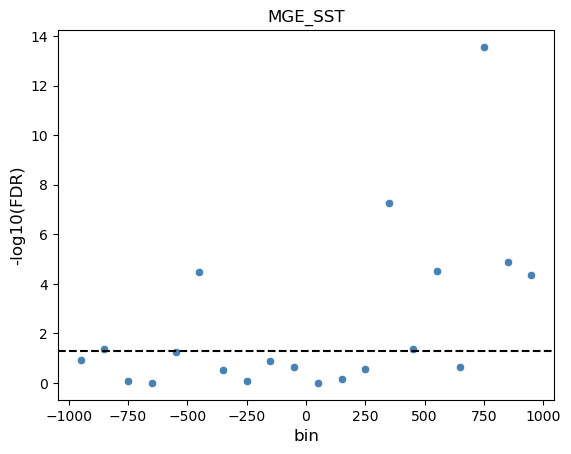

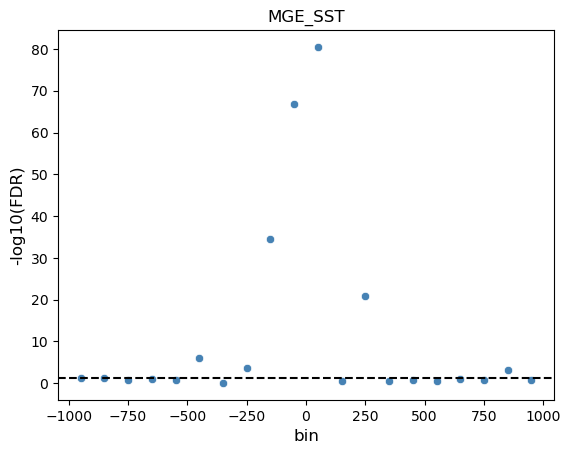

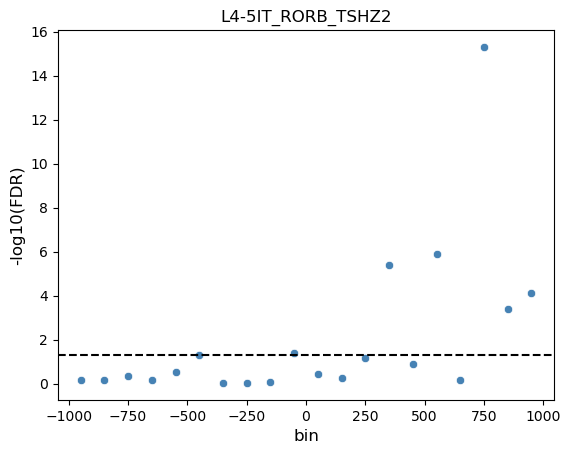

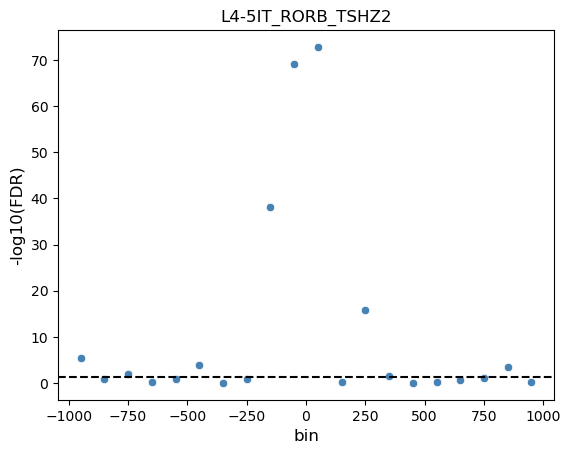

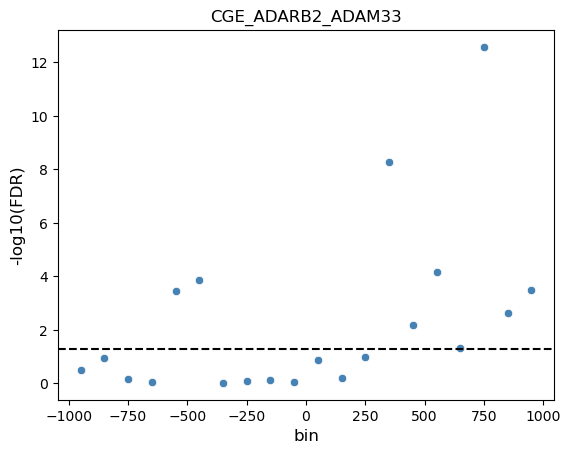

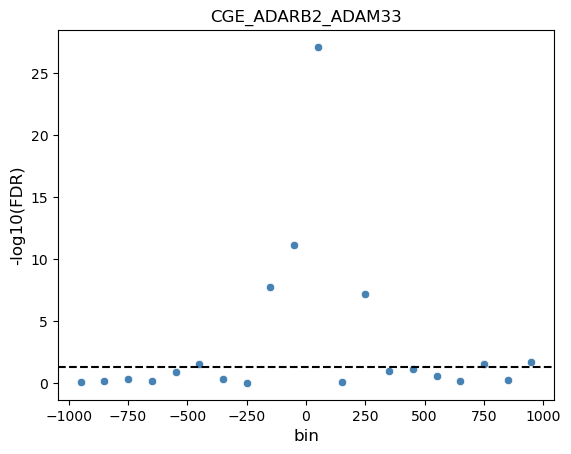

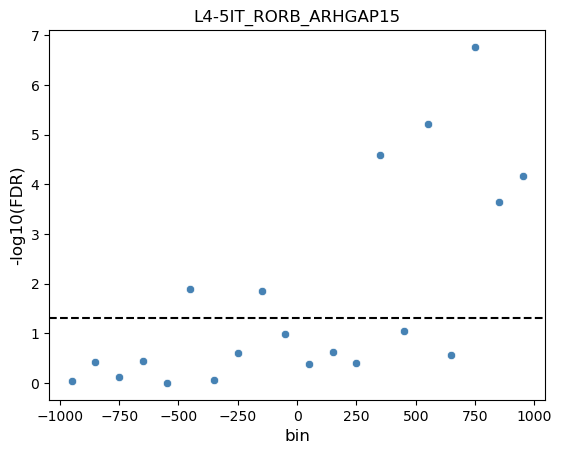

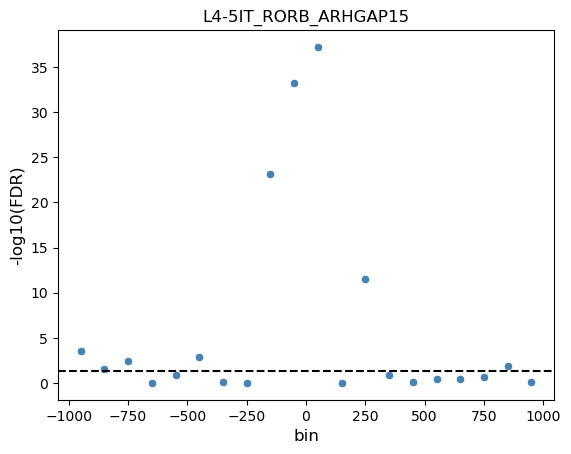

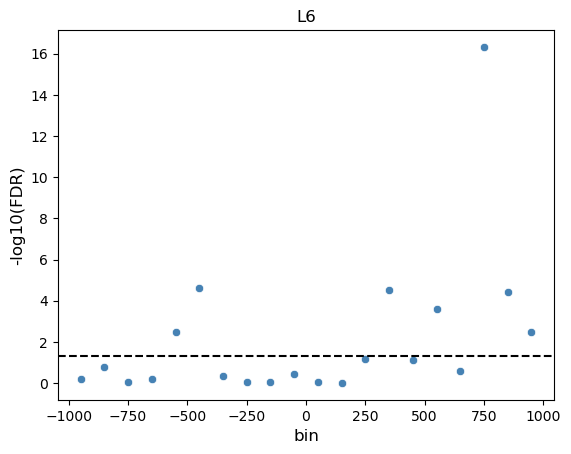

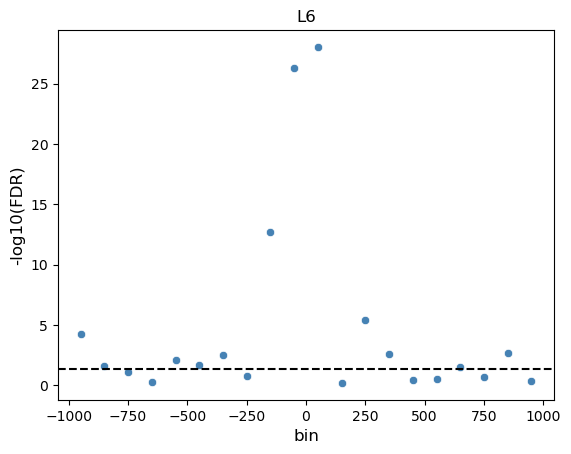

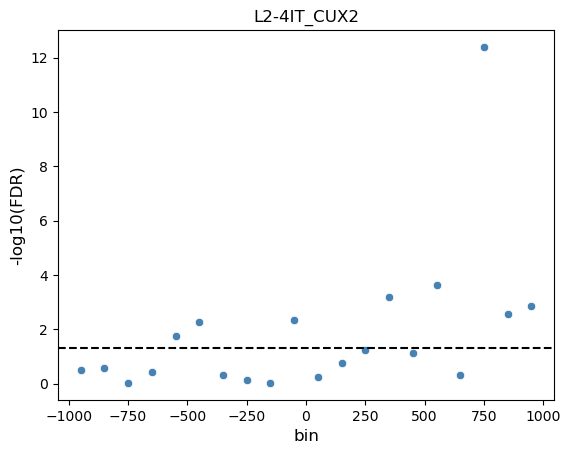

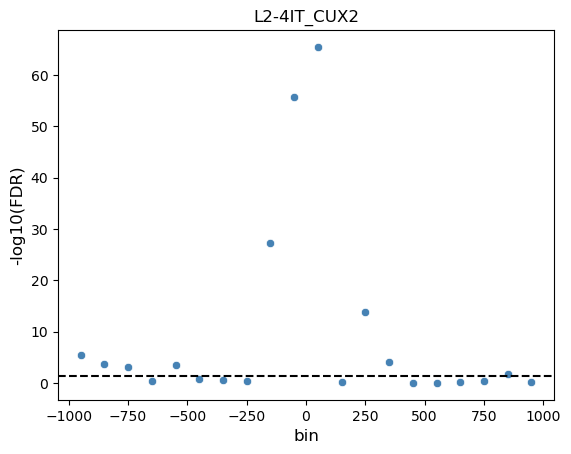

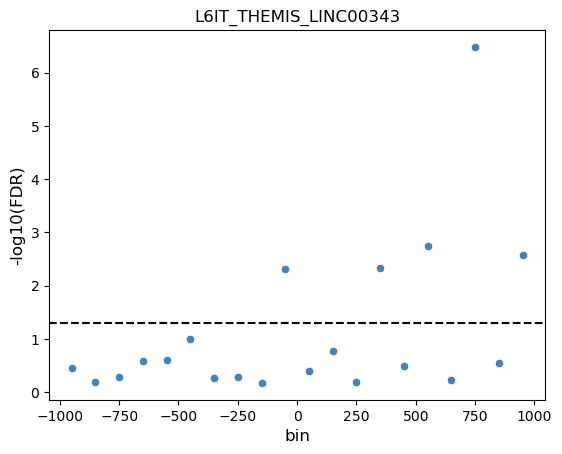

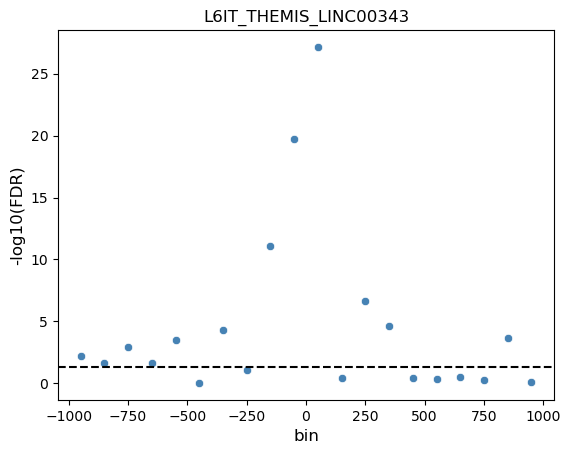

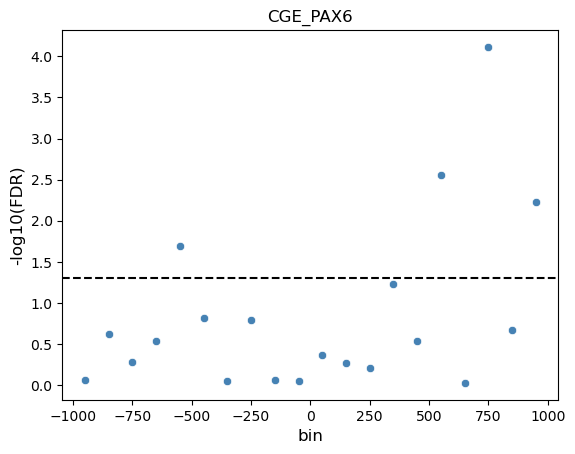

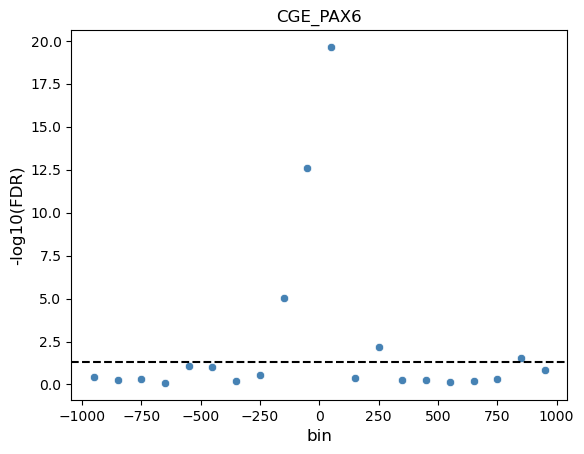

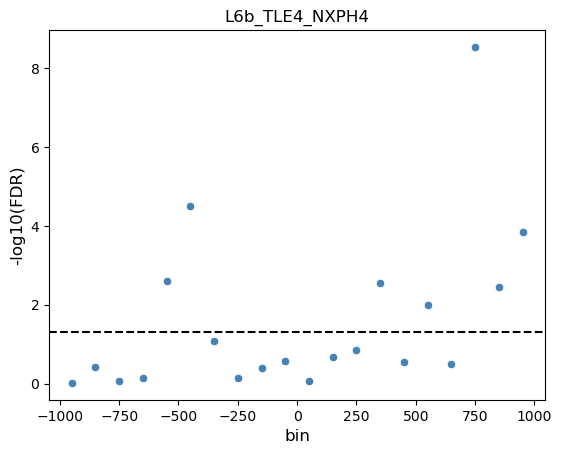

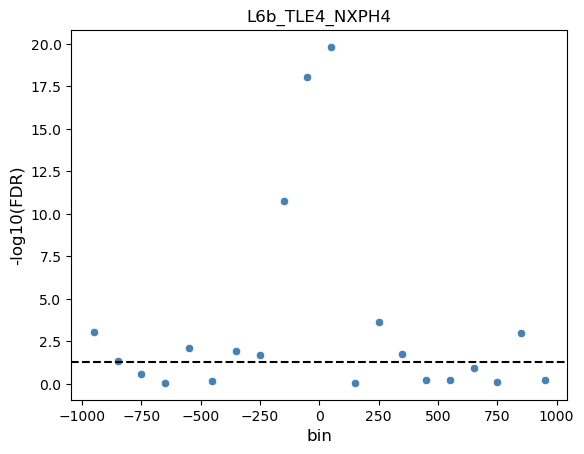

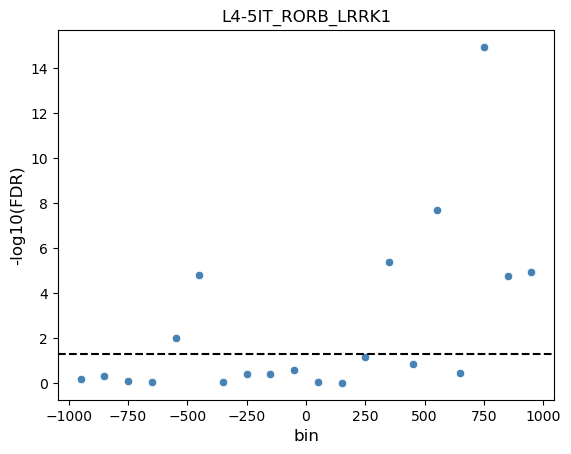

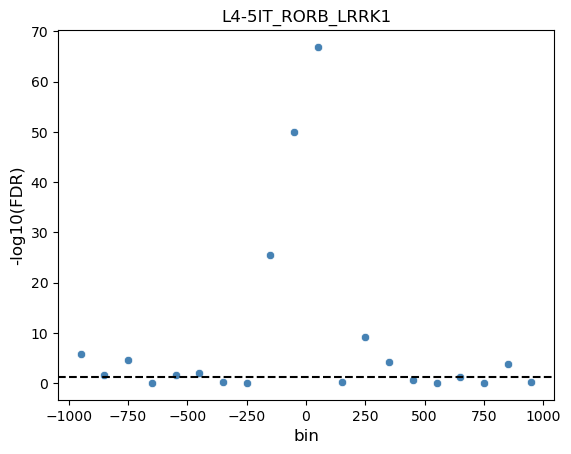

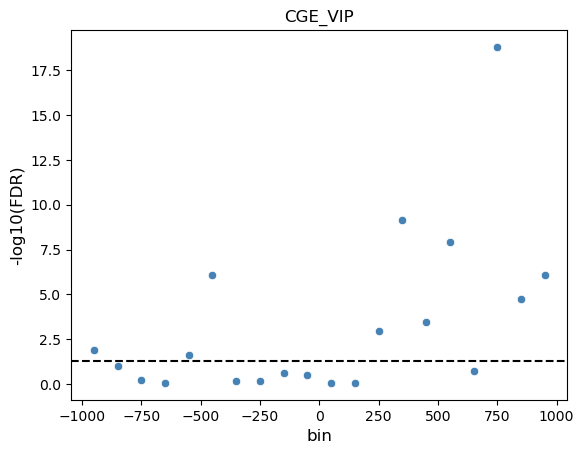

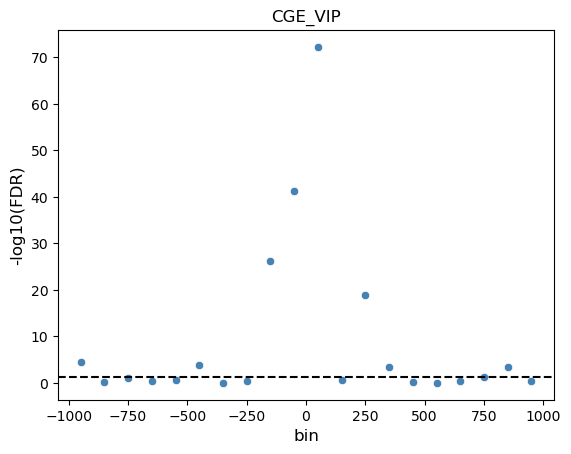

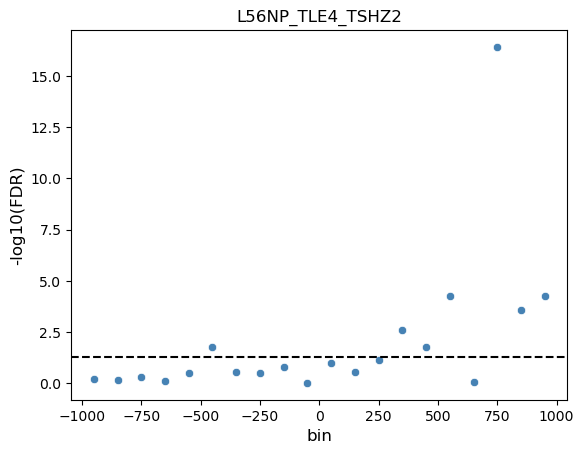

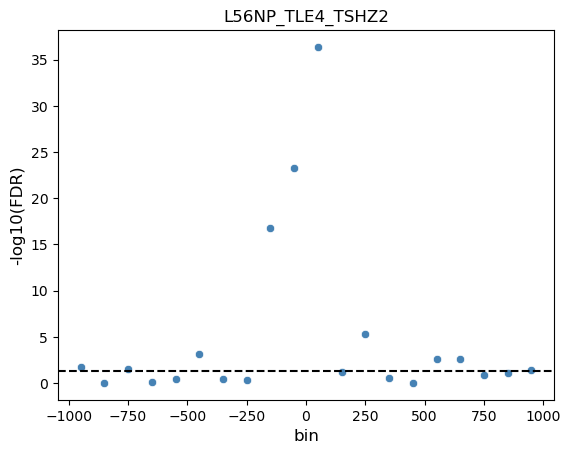

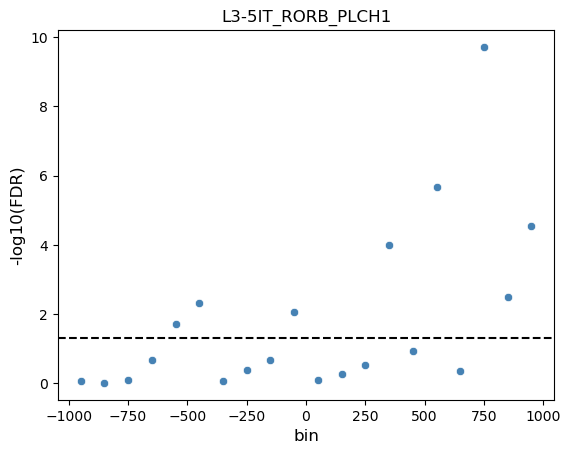

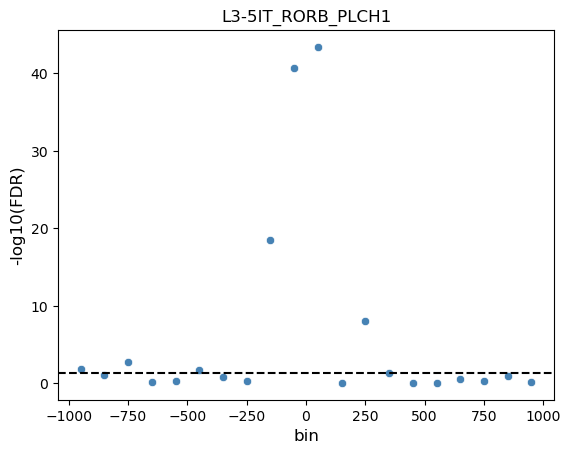

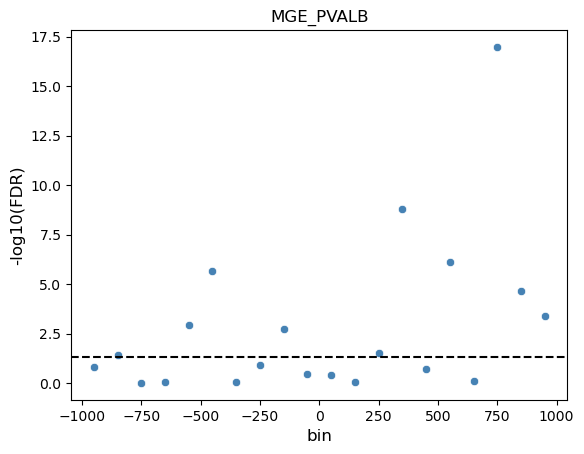

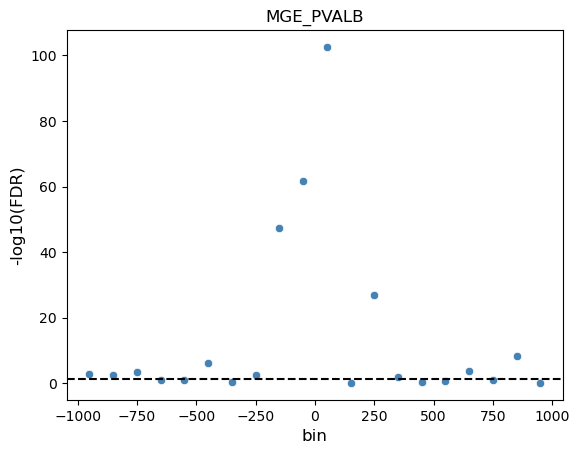

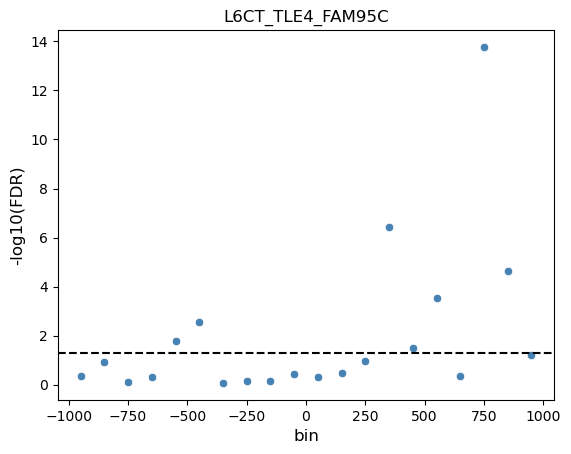

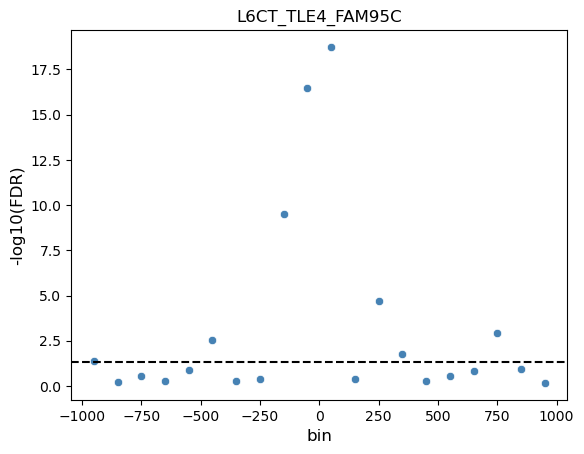

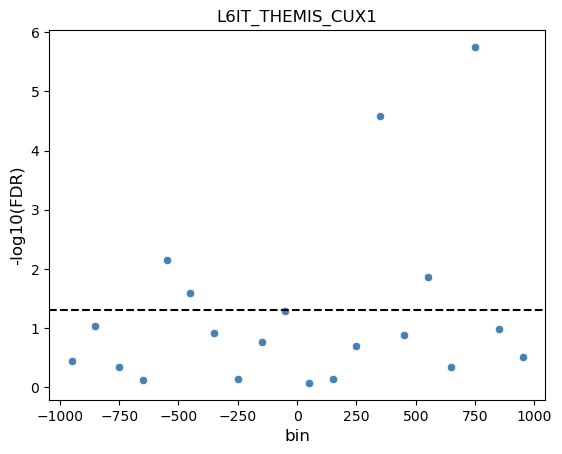

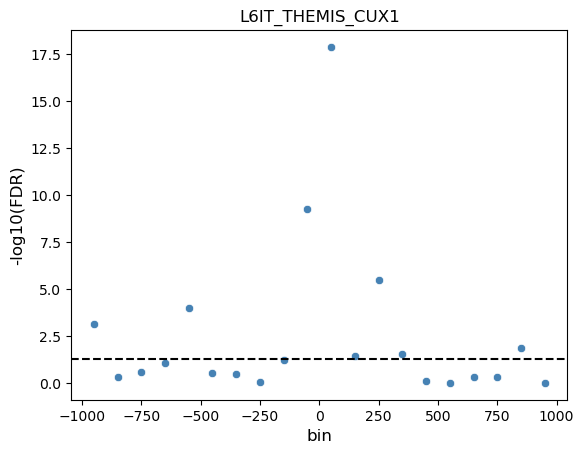

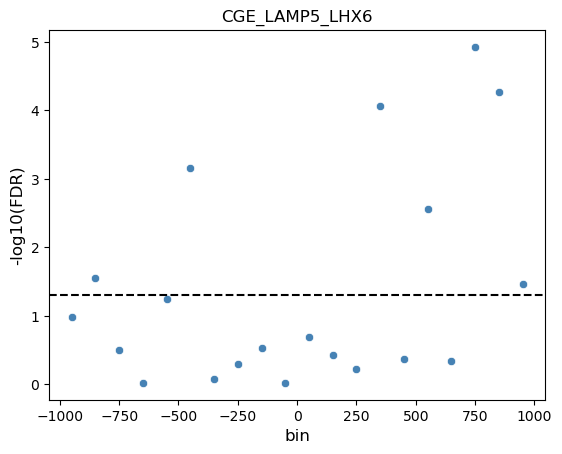

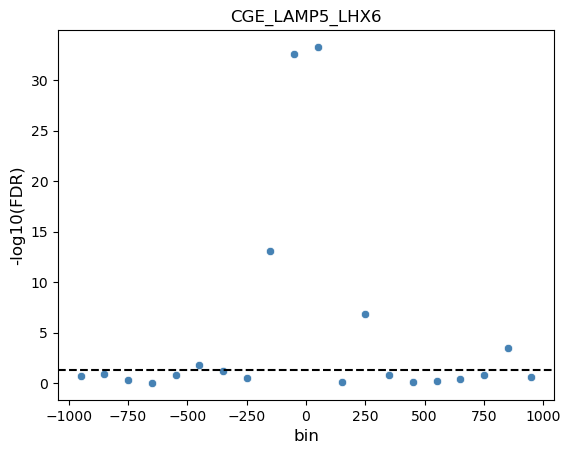

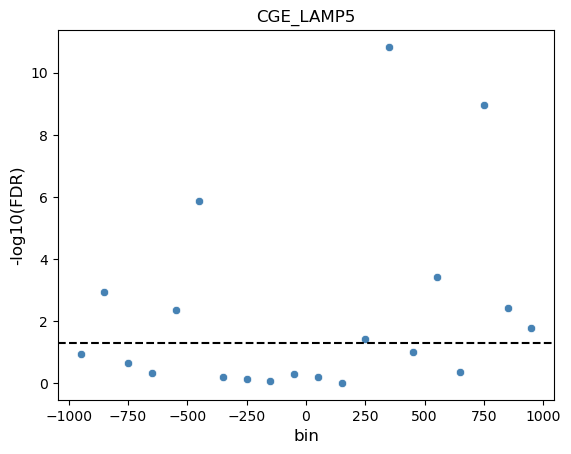

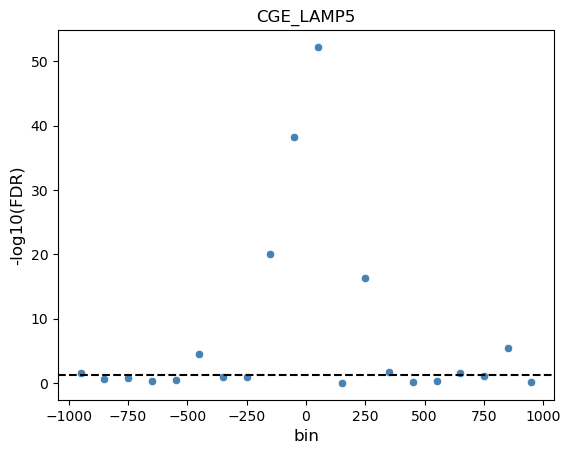

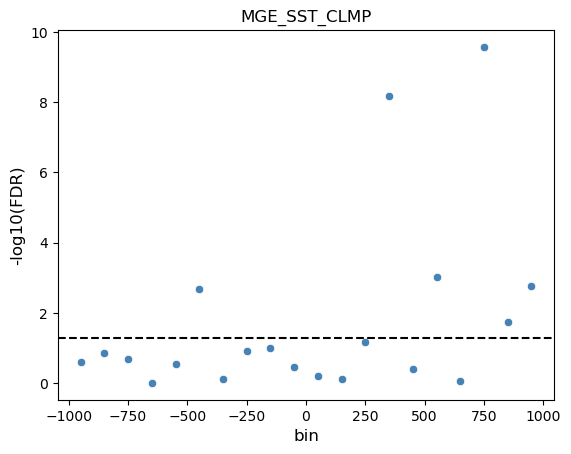

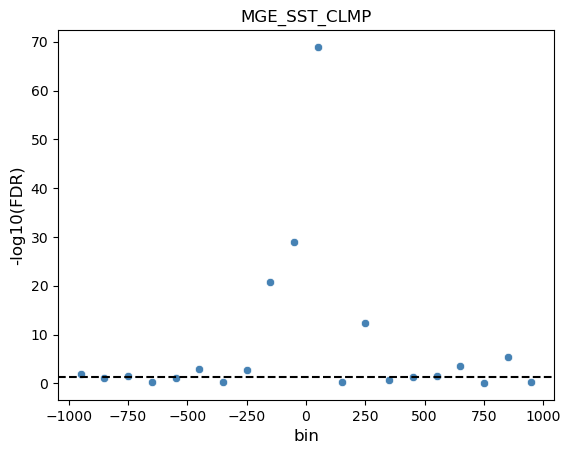

In [67]:
for ct in celltypes:
    for ctxt in contexts:
        df_scatter = dfp[(dfp['celltype'] == ct) & (dfp['ctxt'] == ctxt)]
        plt.figure()
        ax = sns.scatterplot(df_scatter, x='bin', y='-log10(FDR)', color='steelblue')
        ax.axhline(y=-np.log10(0.05), xmin=0, xmax=1, linestyle='--', color='black') 
        plt.title(ct)

In [161]:
if 'L1' in me_type:
    xlim = [-2000,2000]
elif 'Alu' in me_type:
    xlim = [-1000,1000]

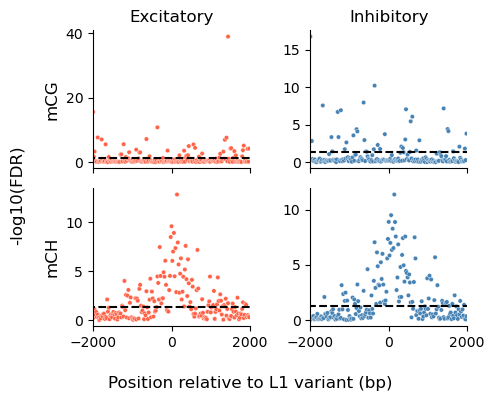

In [162]:
g = sns.relplot(fdr, kind='scatter',
                x='bin', y='-log10(FDR)',
                hue='cell class', hue_order=['Exc', 'Inh'],
                height=2, aspect=1.25, 
                row='ctxt', row_order=['mCGN', 'mCHN'], 
                col='cell class', col_order=['Exc', 'Inh'],
                palette=['tomato','steelblue'], legend=False, s=10,
                facet_kws={'sharey': False, 'sharex': True})

axes = g.axes.flatten()

axes[0].set_title("Excitatory")
axes[0].set_ylabel("mCG")
axes[1].set_title("Inhibitory")
axes[2].set_title("")
axes[2].set_xlabel("")
axes[2].set_ylabel("mCH")
axes[3].set_xlabel("")
axes[3].set_title("")

g.figure.supxlabel(f'Position relative to {me_type} variant (bp)')
g.figure.supylabel('-log10(FDR)')

[ax.axhline(y=-np.log10(0.05), xmin=xlim[0], xmax=xlim[1], linestyle='--', color='black') for ax in axes]
plt.xlim(xlim)
plt.tight_layout()

g.figure.savefig(f'{outdir}/plots/{me_type}_{var}_anova_pvals.pdf', bbox_inches='tight');